In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 250
nA = 2
seed = 2184109
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, gamma=gamma, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)



In [2]:
episodes = 10000
status_step = 10000
alpha = 0.25
alpha_tau = 0.003
results = {"Qs": [], "taus": [], "steps": 0, "visit_distributions": []}

Q = np.zeros((nS, nA))
while tau < 1.00001 and tau > 0:
    res = Q_learning(tmdp, Q, episodes=episodes, alpha=alpha, status_step=status_step)
    Q = res["Qs"][-1]
    visit_dist = res["visit_distributions"][-1]
    results["steps"] += episodes
    
    pi = get_policy(Q)

    r_s_a_xi = compute_r_s_a(tmdp.xi, tmdp.reward)
    r_s_a_p = compute_r_s_a(tmdp.P_mat, tmdp.reward)
    r_s_a = compute_r_s_a(tmdp.P_mat_tau, tmdp.reward)

    #d = compute_d(mu, tmdp.P_mat_tau, pi, tmdp.gamma)

    q_p = get_q_hat( tmdp.P_mat, r_s_a_p, tmdp.gamma, Q)
    q_xi = get_q_hat(tmdp.xi, r_s_a_xi, tmdp.gamma, Q)
    grad = compute_grad_j(pi, q_p, q_xi, visit_dist, tmdp.gamma)

    print("Gradient: ", grad)
    if grad < 0:
        tau = max(0, tau + alpha_tau * grad)
        results["Qs"].append(Q)
        results["taus"].append(tmdp.tau)
        results["visit_distributions"].append(visit_dist)
        print("Updating tau from {} to {}".format(tmdp.tau, tau))
        tmdp.update_tau(tau)

Gradient:  -0.18462439024390248
Updating tau from 1.0 to 0.9994461268292683
Gradient:  -0.22473379662338702
Updating tau from 0.9994461268292683 to 0.9987719254393981
Gradient:  -13.419981291371993
Updating tau from 0.9987719254393981 to 0.9585119815652821
Gradient:  -8.529586876703275
Updating tau from 0.9585119815652821 to 0.9329232209351722
Gradient:  -9.524704690609893
Updating tau from 0.9329232209351722 to 0.9043491068633426
Gradient:  -0.15880669916007362
Updating tau from 0.9043491068633426 to 0.9038726867658624
Gradient:  -0.17712338093689406
Updating tau from 0.9038726867658624 to 0.9033413166230517
Gradient:  -0.2241078392510257
Updating tau from 0.9033413166230517 to 0.9026689931052987
Gradient:  -0.22616888820316364
Updating tau from 0.9026689931052987 to 0.9019904864406892
Gradient:  -0.1368585973559579
Updating tau from 0.9019904864406892 to 0.9015799106486214
Gradient:  -0.23150414084590668
Updating tau from 0.9015799106486214 to 0.9008853982260837
Gradient:  -10.632586

In [3]:
Q_star = bellman_optimal_q(tmdp.P_mat, tmdp.reward, tmdp.gamma)["Q"]
print(len(results["Qs"]))

metrics_curr = compute_metrics(tmdp, results["Qs"], Q_star, results["visit_distributions"])


51


In [ ]:

print(results["steps"]/50)

51
15800.0


In [4]:
print(results["steps"])
Q_0 = np.zeros((nS, nA))
res_0 = Q_learning(tmdp, Q_0, episodes=results["steps"], alpha=alpha, status_step=math.floor(results["steps"]/len(results["Qs"])))



760000


In [5]:
print(len(res_0["Qs"]))
print(len(results["Qs"]))

53
51


In [6]:
diff = len(res_0["Qs"]) - len(results["Qs"])
print(diff)
if diff > 0:
    for i in range(diff):
        res_0["Qs"].pop(i)
        res_0["visit_distributions"].pop(i)


2


In [7]:
print(len(res_0["Qs"]))

51


In [8]:
metrics_0 = compute_metrics(tmdp, res_0["Qs"], Q_star, res_0["visit_distributions"])

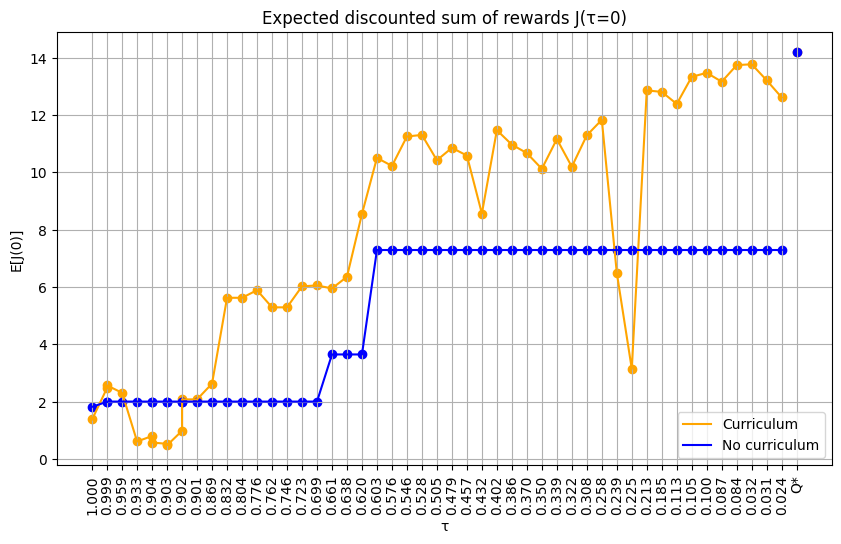

In [15]:
x = np.array([])
y_0 = np.array([])
y = np.array([])

for i, J in enumerate(metrics_curr["J"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, metrics_0["J"][i])
    if i < len(metrics_curr["J"])-1:
        x = np.append(x, "{:.3f}".format(results["taus"][i]))
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.figure(figsize=(10,5.625))
plt.xticks(rotation=90, fontsize=10)
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")
plt.plot(x[:-1], y[:-1], c="orange", label="Curriculum")
plt.plot(x[:-1], y_0[:-1], c="blue", label="No curriculum")
plt.legend(loc="lower right")
plt.xlabel("τ")
plt.ylabel("E[J(0)]")
plt.title("Expected discounted sum of rewards J(τ=0)")
plt.grid(visible=True)

In [10]:
# Evaluating performance of the final policy
J_final = get_expected_avg_reward(tmdp.P_mat, get_policy(results["Qs"][-1]), tmdp.reward, tmdp.gamma, tmdp.mu)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
J_0 = get_expected_avg_reward(tmdp.P_mat, get_policy(res_0["Qs"][-1]), tmdp.reward, tmdp.gamma, tmdp.mu)

print("J_final: ", J_final)
print("J_star: ", J_star)
print("J_0: ", J_0)

J_final:  12.607596750714237
J_star:  14.209656304397933
J_0:  7.286662643323082
